In [1]:
import pandas as pd, sqlite3, numpy as np
from pathlib import Path

DB = "mimic_demo.db"
conn = sqlite3.connect(DB)

# Load CSVs -> SQLite (adjust filenames to the actual ones you download)
def load(name, path):
    df = pd.read_csv(path)
    df.to_sql(name, conn, if_exists='replace', index=False)
    return df.shape

print("Admissions", load("admissions", "/content/drive/MyDrive/Colab Notebooks/data/admissions.csv"))
print("Patients",  load("patients",   "/content/drive/MyDrive/Colab Notebooks/data/patients.csv"))
print("Diagnoses", load("diagnoses",  "/content/drive/MyDrive/Colab Notebooks/data/diagnoses_icd.csv"))
print("Labs",      load("labevents",  "/content/drive/MyDrive/Colab Notebooks/data/labevents.csv"))
print("d_icd",     load("d_icd",      "/content/drive/MyDrive/Colab Notebooks/data/d_icd_diagnoses.csv"))
print("d_lab",     load("d_lab",      "/content/drive/MyDrive/Colab Notebooks/data/d_labitems.csv"))


Admissions (275, 16)
Patients (100, 6)
Diagnoses (4506, 5)
Labs (107727, 16)
d_icd (109775, 3)
d_lab (1622, 4)


In [2]:
import pandas as pd, sqlite3
conn = sqlite3.connect("mimic_demo.db")

paths = {
  "admissions": "/content/drive/MyDrive/Colab Notebooks/data/admissions.csv",
  "patients":   "/content/drive/MyDrive/Colab Notebooks/data/patients.csv",
  "diagnoses":  "/content/drive/MyDrive/Colab Notebooks/data/diagnoses_icd.csv",
  "labevents":  "/content/drive/MyDrive/Colab Notebooks/data/labevents.csv",
  "d_icd":      "/content/drive/MyDrive/Colab Notebooks/data/d_icd_diagnoses.csv",
  "d_lab":      "/content/drive/MyDrive/Colab Notebooks/data/d_labitems.csv",
}

for name, p in paths.items():
    df = pd.read_csv(p)
    df.to_sql(name, conn, if_exists="replace", index=False)
    print(f"Loaded {name}: {df.shape}")


Loaded admissions: (275, 16)
Loaded patients: (100, 6)
Loaded diagnoses: (4506, 5)
Loaded labevents: (107727, 16)
Loaded d_icd: (109775, 3)
Loaded d_lab: (1622, 4)


In [3]:
import os, pandas as pd, numpy as np, sqlite3, matplotlib.pyplot as plt
from pathlib import Path

OUT = Path("/content/drive/MyDrive/Colab Notebooks/outputs")
OUT.mkdir(parents=True, exist_ok=True)

conn = sqlite3.connect("mimic_demo.db")
conn.executescript("""
CREATE INDEX IF NOT EXISTS idx_adm_hadm ON admissions(hadm_id);
CREATE INDEX IF NOT EXISTS idx_adm_subj ON admissions(subject_id);
CREATE INDEX IF NOT EXISTS idx_pat_subj ON patients(subject_id);
CREATE INDEX IF NOT EXISTS idx_dx_subj  ON diagnoses(subject_id);
CREATE INDEX IF NOT EXISTS idx_dx_code  ON diagnoses(icd_code, icd_version);
CREATE INDEX IF NOT EXISTS idx_lab_item ON labevents(itemid);
CREATE INDEX IF NOT EXISTS idx_lab_subj ON labevents(subject_id);
""");
print("Indexes created. Outputs will be saved to:", OUT)


Indexes created. Outputs will be saved to: /content/drive/MyDrive/Colab Notebooks/outputs


In [4]:
gender_df = pd.read_sql_query("""
SELECT gender,
       COUNT(*) AS n,
       ROUND(100.0 * COUNT(*) / SUM(COUNT(*)) OVER(), 2) AS pct
FROM patients
GROUP BY gender
ORDER BY n DESC;
""", conn)
gender_df.to_csv(OUT/"gender_distribution.csv", index=False)
gender_df


,gender,n,pct
0,M,57,57.0
1,F,43,43.0


In [5]:
pcols = set(pd.read_sql_query("SELECT * FROM patients LIMIT 0;", conn).columns)
acols = set(pd.read_sql_query("SELECT * FROM admissions LIMIT 0;", conn).columns)

if "dob" in pcols and "admittime" in acols:
    ages = pd.read_sql_query("""
    WITH first_adm AS (
      SELECT subject_id, MIN(admittime) AS first_admit
      FROM admissions GROUP BY subject_id
    )
    SELECT (julianday(f.first_admit) - julianday(p.dob)) / 365.2425 AS age
    FROM patients p JOIN first_adm f USING(subject_id)
    WHERE p.dob IS NOT NULL AND f.first_admit IS NOT NULL
    """, conn)["age"].dropna()
elif "anchor_age" in pcols:
    ages = pd.read_sql_query("SELECT anchor_age AS age FROM patients WHERE anchor_age IS NOT NULL", conn)["age"].dropna()
else:
    raise ValueError("Need dob+admittime or anchor_age to compute age.")

age_summary = pd.DataFrame({
    "avg_age":[float(ages.mean())],
    "median_age":[float(np.median(ages))]
})
age_summary.to_csv(OUT/"age_summary.csv", index=False)
age_summary


,avg_age,median_age
0,61.75,63.0


Mean LOS: 6.88 days


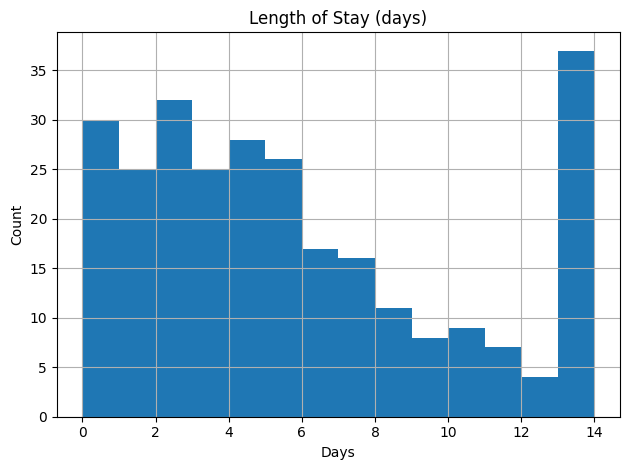

In [6]:
los_df = pd.read_sql_query("""
SELECT (julianday(dischtime) - julianday(admittime)) AS los
FROM admissions
WHERE dischtime IS NOT NULL AND admittime IS NOT NULL
""", conn)

los_mean = float(los_df["los"].mean())
print("Mean LOS:", round(los_mean, 2), "days")

ax = los_df["los"].clip(lower=0, upper=14).hist(bins=list(range(0,15)))
ax.set_title("Length of Stay (days)")
ax.set_xlabel("Days"); ax.set_ylabel("Count")
plt.tight_layout()
plt.savefig(OUT/"los_hist_0_14.png", dpi=160, bbox_inches="tight")
los_df.to_csv(OUT/"los_values.csv", index=False)


In [7]:
avg_unique_icd = pd.read_sql_query("""
WITH per_patient AS (
  SELECT subject_id,
         COUNT(DISTINCT icd_code || ':' || icd_version) AS uniq_icd
  FROM diagnoses
  GROUP BY subject_id
)
SELECT AVG(uniq_icd) AS avg_unique_icd_per_patient FROM per_patient;
""", conn)
avg_unique_icd.to_csv(OUT/"avg_unique_icd_per_patient.csv", index=False)
avg_unique_icd


,avg_unique_icd_per_patient
0,32.23


In [8]:
q2 = """
WITH u AS (
  SELECT DISTINCT d.subject_id, d.icd_code, d.icd_version, di.long_title
  FROM diagnoses d
  JOIN d_icd di
    ON di.icd_code = d.icd_code AND di.icd_version = d.icd_version
)
SELECT
  subject_id,
  GROUP_CONCAT(icd_code || ':' || icd_version || ' - ' || long_title, ' | ') AS unique_icd_codes
FROM u
GROUP BY subject_id
ORDER BY subject_id;
"""
df2 = pd.read_sql_query(q2, conn)
df2.head()


,subject_id,unique_icd_codes
0,10000032,2761:9 - Hyposmolality and/or hyponatremia | V...
1,10001217,V168:9 - Family history of other specified mal...
2,10001725,"49390:9 - Asthma, unspecified type, unspecifie..."
3,10002428,4019:9 - Unspecified essential hypertension | ...
4,10002495,R310:10 - Gross hematuria | N179:10 - Acute ki...


In [9]:
top_icd = pd.read_sql_query("""
WITH counts AS (
  SELECT icd_code, icd_version, COUNT(*) AS cnt
  FROM diagnoses GROUP BY icd_code, icd_version
),
tot AS (SELECT SUM(cnt) AS total FROM counts)
SELECT c.icd_code, c.icd_version, di.long_title, c.cnt,
       ROUND(100.0 * c.cnt / (SELECT total FROM tot), 2) AS percent
FROM counts c
JOIN d_icd di
  ON di.icd_code = c.icd_code AND di.icd_version = c.icd_version
ORDER BY c.cnt DESC
LIMIT 10;
""", conn)
top_icd.to_csv(OUT/"top10_icd.csv", index=False)
top_icd


,icd_code,icd_version,long_title,cnt,percent
0,4019,9,Unspecified essential hypertension,68,1.51
1,E785,10,"Hyperlipidemia, unspecified",57,1.26
2,2724,9,Other and unspecified hyperlipidemia,55,1.22
3,E039,10,"Hypothyroidism, unspecified",47,1.04
4,Z794,10,Long term (current) use of insulin,37,0.82
5,Z87891,10,Personal history of nicotine dependence,35,0.78
6,42731,9,Atrial fibrillation,34,0.75
7,25000,9,Diabetes mellitus without mention of complicat...,33,0.73
8,I2510,10,Atherosclerotic heart disease of native corona...,33,0.73
9,F329,10,"Major depressive disorder, single episode, uns...",32,0.71


In [10]:
lcols = set(pd.read_sql_query("SELECT * FROM labevents LIMIT 0;", conn).columns)
assert "itemid" in lcols, f"Expected 'itemid' in labevents, found: {lcols}"
assert "valuenum" in lcols, f"Expected 'valuenum' in labevents, found: {lcols}"
assert "value" in lcols, f"Expected 'value' in labevents, found: {lcols}"

lab_stats = pd.read_sql_query("""
SELECT dl.label,
       AVG(le.valuenum) AS numeric_mean,
       ROUND(100.0 * SUM(CASE WHEN le.value IS NULL THEN 1 ELSE 0 END) / COUNT(*), 2) AS missing_percent
FROM labevents le
JOIN d_lab dl ON dl.itemid = le.itemid
GROUP BY dl.label
ORDER BY COUNT(*) DESC
""", conn)
lab_stats.to_csv(OUT/"lab_label_stats.csv", index=False)
lab_stats.head(20)


,label,numeric_mean,missing_percent
0,Glucose,151.672590,7.64
1,Potassium,4.194700,0.10
2,Sodium,137.478883,0.00
3,Creatinine,1.541592,0.00
4,Chloride,101.070111,0.00
5,Urea Nitrogen,27.890346,0.03
6,Hemoglobin,10.079781,0.07
7,Hematocrit,30.783494,0.17
8,Bicarbonate,24.881593,0.00
9,Anion Gap,14.952448,0.00


In [11]:
import pandas as pd, sqlite3, re
from pathlib import Path

conn = sqlite3.connect("mimic_demo.db")

# Prefer the files inside the ".../split/" folder if they exist
candidates = [
    Path("/content/drive/MyDrive/Colab Notebooks/data/split/patient_1.csv"),
    Path("/content/drive/MyDrive/Colab Notebooks/data/split/patient_2.csv"),
    Path("/content/drive/MyDrive/Colab Notebooks/data/patient_1.csv"),
    Path("/content/drive/MyDrive/Colab Notebooks/data/patient_2.csv"),
    Path("data/patient_1.csv"),
    Path("data/patient_2.csv"),
]
files = [p for p in candidates if p.exists()]
p1 = next((p for p in files if re.search(r"patient[_-]?1\.csv$", p.name, re.I)), None)
p2 = next((p for p in files if re.search(r"patient[_-]?2\.csv$", p.name, re.I)), None)
print("Using:", p1, p2)

def mean_age_from_patient_only(p_csv):
    """Compute (sum_age, n) for one split without centralizing patients across splits."""
    dfp = pd.read_csv(p_csv)
    dfp.to_sql("patients_tmp", conn, if_exists="replace", index=False)
    cols = set(dfp.columns)

    if "anchor_age" in cols:
        # MIMIC-IV style: age is already provided
        r = pd.read_sql_query("""
            SELECT SUM(anchor_age) AS sum_age,
                   COUNT(anchor_age) AS n
            FROM patients_tmp
            WHERE anchor_age IS NOT NULL
        """, conn).iloc[0]
        return float(r["sum_age"] or 0.0), int(r["n"] or 0)

    elif "dob" in cols:
        # MIMIC-III style: compute age at first admission using the GLOBAL admissions table
        r = pd.read_sql_query("""
        WITH first_adm AS (
          SELECT subject_id, MIN(admittime) AS first_admit
          FROM admissions
          WHERE subject_id IN (SELECT subject_id FROM patients_tmp)
          GROUP BY subject_id
        ),
        ages AS (
          SELECT (julianday(f.first_admit) - julianday(p.dob)) / 365.2425 AS age
          FROM patients_tmp p JOIN first_adm f USING(subject_id)
          WHERE p.dob IS NOT NULL AND f.first_admit IS NOT NULL
        )
        SELECT SUM(age) AS sum_age, COUNT(*) AS n FROM ages
        """, conn).iloc[0]
        return float(r["sum_age"] or 0.0), int(r["n"] or 0)

    else:
        raise ValueError(f"Neither 'anchor_age' nor 'dob' found in {p_csv.name}; cols={cols}")

sum_age, n = 0.0, 0
for p in [p1, p2]:
    if p is None:
        continue
    s, k = mean_age_from_patient_only(p)
    print(p.name, "-> n:", k)
    sum_age += s; n += k

combined_mean_age = (sum_age / n) if n else None
print("Combined mean age across splits:", combined_mean_age)

# Compare to your Set #1 (overall) mean:
import pandas as pd
overall_mean_age = float(pd.read_csv("/content/drive/MyDrive/Colab Notebooks/outputs/age_summary.csv")["avg_age"].iloc[0])
print("Overall mean age (Set #1):", overall_mean_age)


Using: /content/drive/MyDrive/Colab Notebooks/data/split/patient_1.csv /content/drive/MyDrive/Colab Notebooks/data/split/patient_2.csv
patient_1.csv -> n: 50
patient_2.csv -> n: 50
Combined mean age across splits: 61.75
Overall mean age (Set #1): 61.75
